In [1]:
import os
import sys
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import mixed_precision

from utils.label_utils import get_labels, get_train_labels
from models.u2net import U2NET, U2NET_lite
from models.unet import unet, unet_small
from models.deeplabv3_xception import deeplabv3, deeplabv3_lite

physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
K.clear_session()

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices,"\n")
enable_amp() 

Tensorflow version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

In [3]:
def read_tfrecord(serialized_example):
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string),
        'segmentation': tf.io.FixedLenFeature((), tf.string),
        'height': tf.io.FixedLenFeature((), tf.int64),
        'width': tf.io.FixedLenFeature((), tf.int64),
        'image_depth': tf.io.FixedLenFeature((), tf.int64),
        'mask_depth': tf.io.FixedLenFeature((), tf.int64),
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    image = tf.io.parse_tensor(example['image'], out_type = tf.uint8)
    image_shape = [example['height'], example['width'], 3]
    image = tf.reshape(image, image_shape)
    mask = tf.io.parse_tensor(example['segmentation'], out_type = tf.uint8)
    mask_shape = [example['height'], example['width'], 1]
    mask = tf.reshape(mask, mask_shape)
    return image, mask


def get_dataset_from_tfrecord(tfrecord_dir):
    tfrecord_dataset = tf.data.TFRecordDataset(tfrecord_dir)
    parsed_dataset = tfrecord_dataset.map(read_tfrecord)
    return parsed_dataset

In [4]:
fine = True

if fine:
    train_tfrecord_dir = 'records/fine_train_cat.tfrecords'
    test_tfrecord_dir = 'records/fine_test_cat.tfrecords'
else:
    train_tfrecord_dir = 'records/coarse_train_cat.tfrecords'
    test_tfrecord_dir = 'records/coarse_test_cat.tfrecords'


img_height = 256
img_width = 512
n_classes = 8

# labels = get_train_labels()
labels = get_labels()
id2label = { label.id : label for label in labels }
trainId2label = { label.trainId : label for label in labels }
catId2label = { label.categoryId : label for label in labels }

Adding the `@tf.function` decorator supposedly makes things faster.

In [5]:
@tf.function
def mask_to_categorical(image, mask):
    mask = tf.squeeze(mask) 
    mask = tf.one_hot(tf.cast(mask, tf.int32), n_classes)
    mask = tf.cast(mask, tf.float32)
    return image, mask


@tf.function
def load_image_train(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    input_mask = tf.image.resize(input_mask, (img_height, img_width))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)

    return input_image, input_mask


def load_image_test(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    input_mask = tf.image.resize(input_mask, (img_height, img_width))
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)

    return input_image, input_mask

In [6]:
if fine:
    TRAIN_LENGTH = 2780
    TEST_LENGTH = 695
else:
    TRAIN_LENGTH = 16000
    TEST_LENGTH = 3998

BATCH_SIZE = 8
BUFFER_SIZE = 1000

In [7]:
train_tfrecords_dataset = get_dataset_from_tfrecord(train_tfrecord_dir)
test_tfrecords_dataset = get_dataset_from_tfrecord(test_tfrecord_dir)

In [8]:
# Preprocessing: resize the images and masks, flip them, 
train = train_tfrecords_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_tfrecords_dataset.map(load_image_test)

In [9]:
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [10]:
def label_to_rgb(mask):
    mask_rgb = np.zeros((img_height, img_width, 3), dtype=np.uint8)
    for i in range(0, n_classes):
        #mask_rgb[mask[:,:,0]==i] = trainId2label[i].color 
        mask_rgb[mask[:,:,0]==i] = catId2label[i].color
        #mask_rgb[mask[:,:,0]==i] = id2label[i].color 
    return mask_rgb


def display(display_list, title=False):
    plt.figure(figsize=(14, 21))
    # plt.figure(figsize=(6, 9))
    if title:
        title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(len(display_list), 1, i+1)
        if title:
            plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

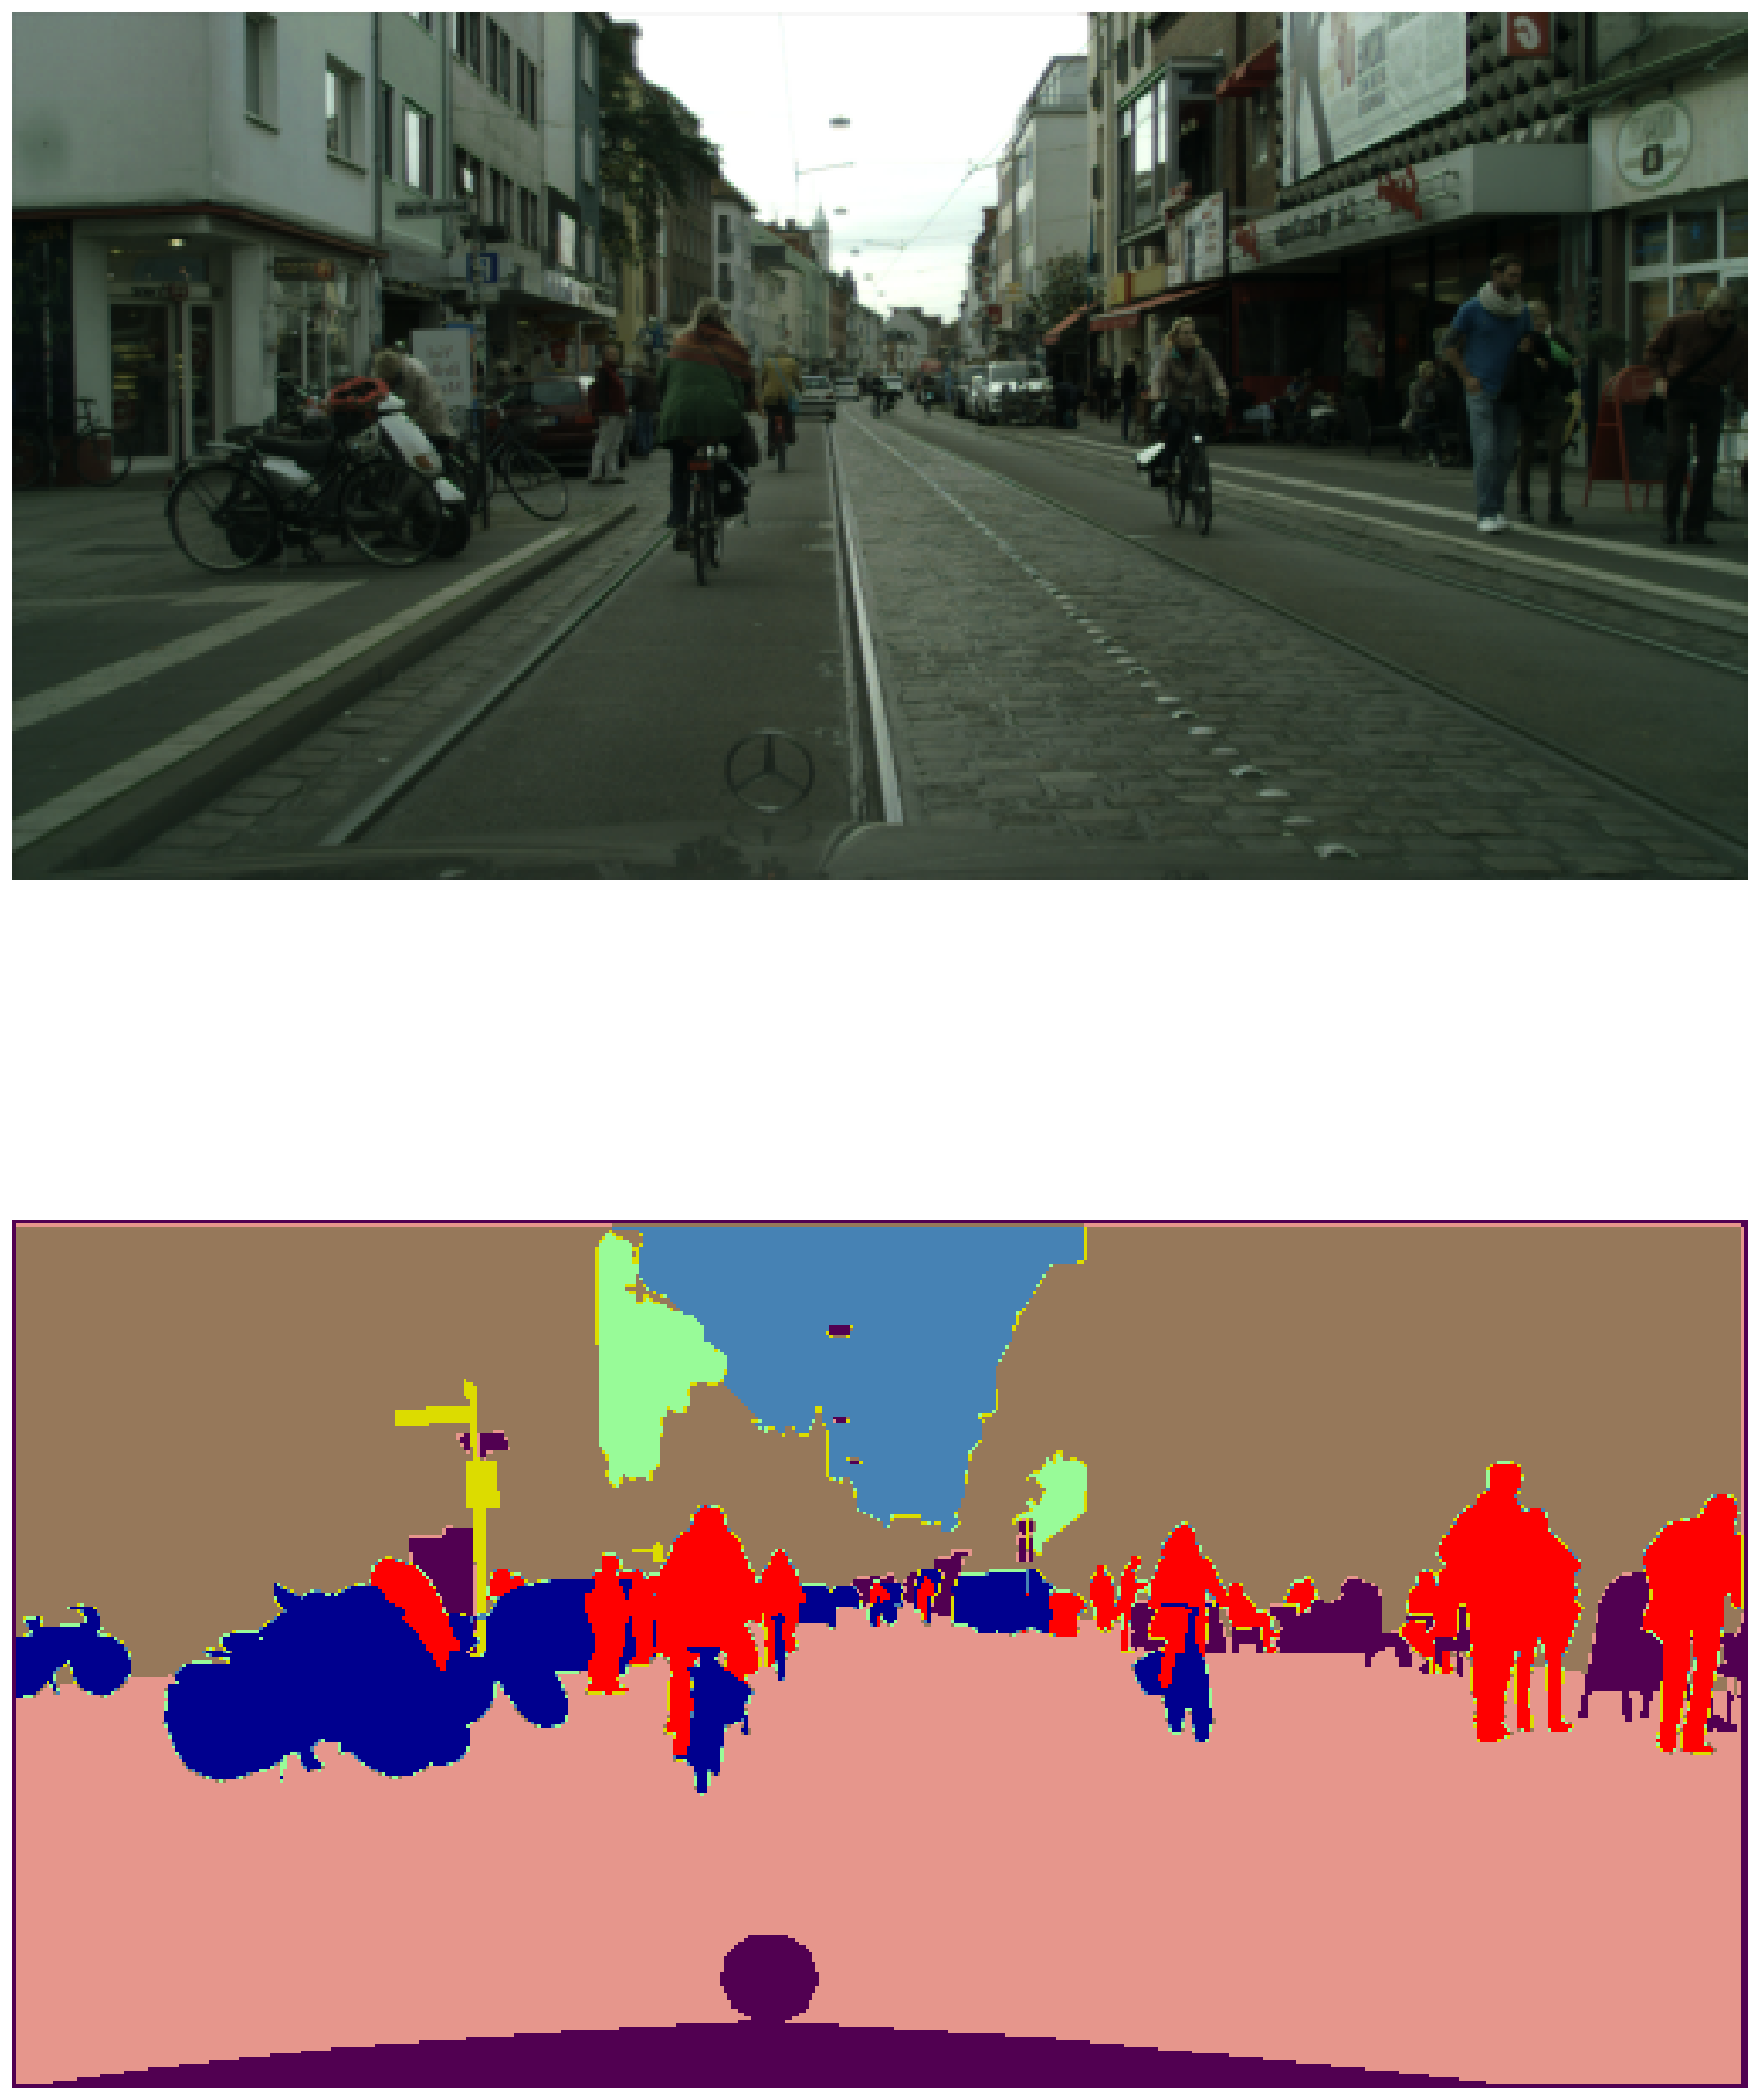

In [11]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    
sample_mask = tf.argmax(sample_mask, axis=-1)
sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

A standard way to train an image segmentation model is using categorical crossentropy loss. This works okay, but it has the drawback of being biased towards classes that are generally larger in the image (ex: roads, trees). So here we define a custom loss function that combines the categorical crossentropy and the average IoU coefficient. 

In [12]:
def iou_coef(y_true, y_pred):
    """When smooth=1, metrics where absent classes contribute to the class mean as 1.0."""
    smooth = 1.0
    intersection = K.sum(y_true * y_pred, axis=(1,2))
    mask_sum = K.sum(y_true, axis=(1,2)) + K.sum(y_pred, axis=(1,2))
    union = mask_sum - intersection
    iou = K.mean((intersection + smooth) / (union + smooth))
    return iou


def cce_iou_loss(y_true, y_pred):
    return (tf.keras.losses.categorical_crossentropy(y_true, y_pred) - iou_coef(y_true, y_pred)) + 1

In [13]:
K.clear_session()
# model = unet(input_height=img_height, input_width=img_width, n_classes=n_classes, act="relu")
# model = unet_small(input_height=img_height, input_width=img_width, n_classes=n_classes, act="relu")
# model = U2NET(input_height=img_height, input_width=img_width, n_classes=n_classes)
# model = U2NET_lite(input_height=img_height, input_width=img_width, n_classes=n_classes)
# model = deeplabv3(input_height=img_height, input_width=img_width, n_classes=n_classes)
model = deeplabv3_lite(input_height=img_height, input_width=img_width, n_classes=n_classes)

To note: the U2Net model has six different outputs (for training), so the `model.predict()` function outputs a list of six tensors. 

In [14]:
def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = label_to_rgb(pred_mask.numpy())
    return pred_mask


def show_predictions():
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if model.name == "u2net":
        pred_mask = pred_mask[0]
    display([sample_image, sample_mask, create_mask(pred_mask)])

        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

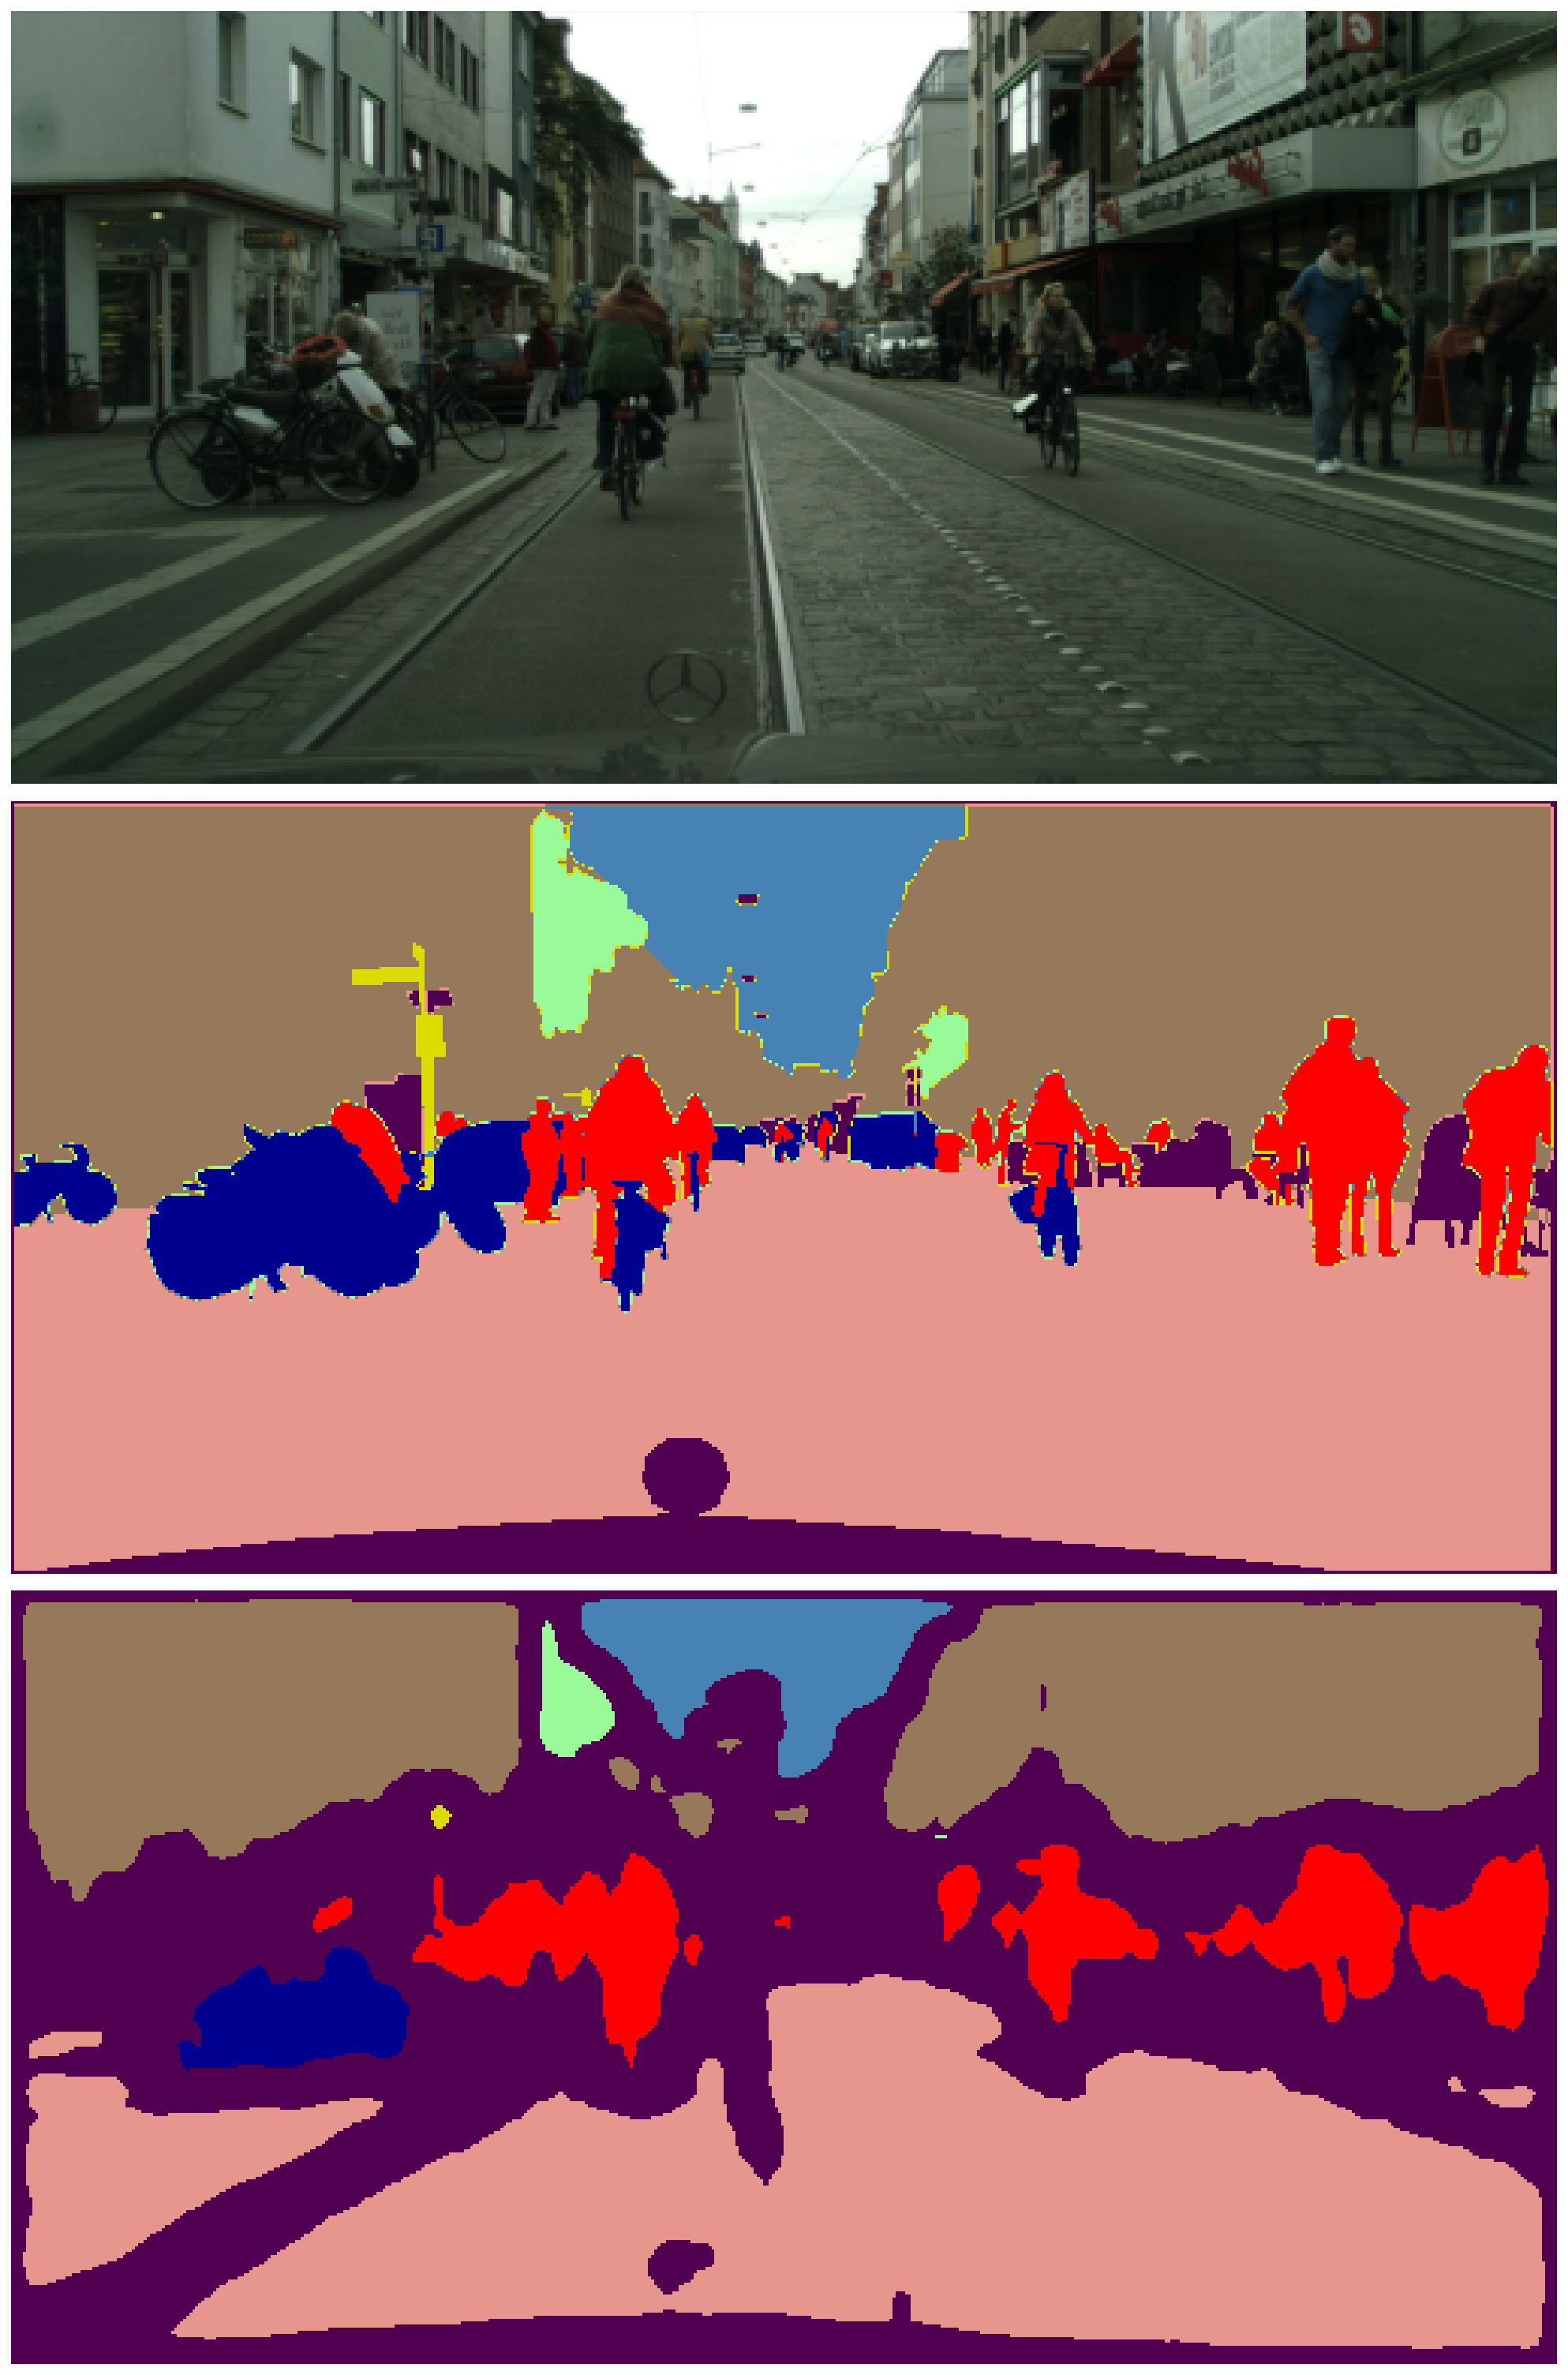

In [22]:
show_predictions()

In [16]:
plot_model(model, show_shapes=True)

In [17]:
model.name

'deeplabv3_xception_lite'

In [18]:
model.compile(
    optimizer = Adam(lr=1e-4),
    loss = cce_iou_loss, 
    metrics = ['accuracy', iou_coef]
)

In [19]:
callbacks = [
    DisplayCallback(),
    EarlyStopping(monitor='val_loss', mode='min', patience=8, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', patience=4, factor=0.1, min_lr=1e-10, verbose=1),
]

In [20]:
EPOCHS = 20
SUBSPLITS = 4
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE // SUBSPLITS
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // SUBSPLITS

In [21]:
PATH_coarse = "weights/"+model.name+"_coarse.h5"
PATH_fine = "weights/"+model.name+".h5"

if os.path.isfile(PATH_coarse):
    model.load_weights(PATH_coarse)

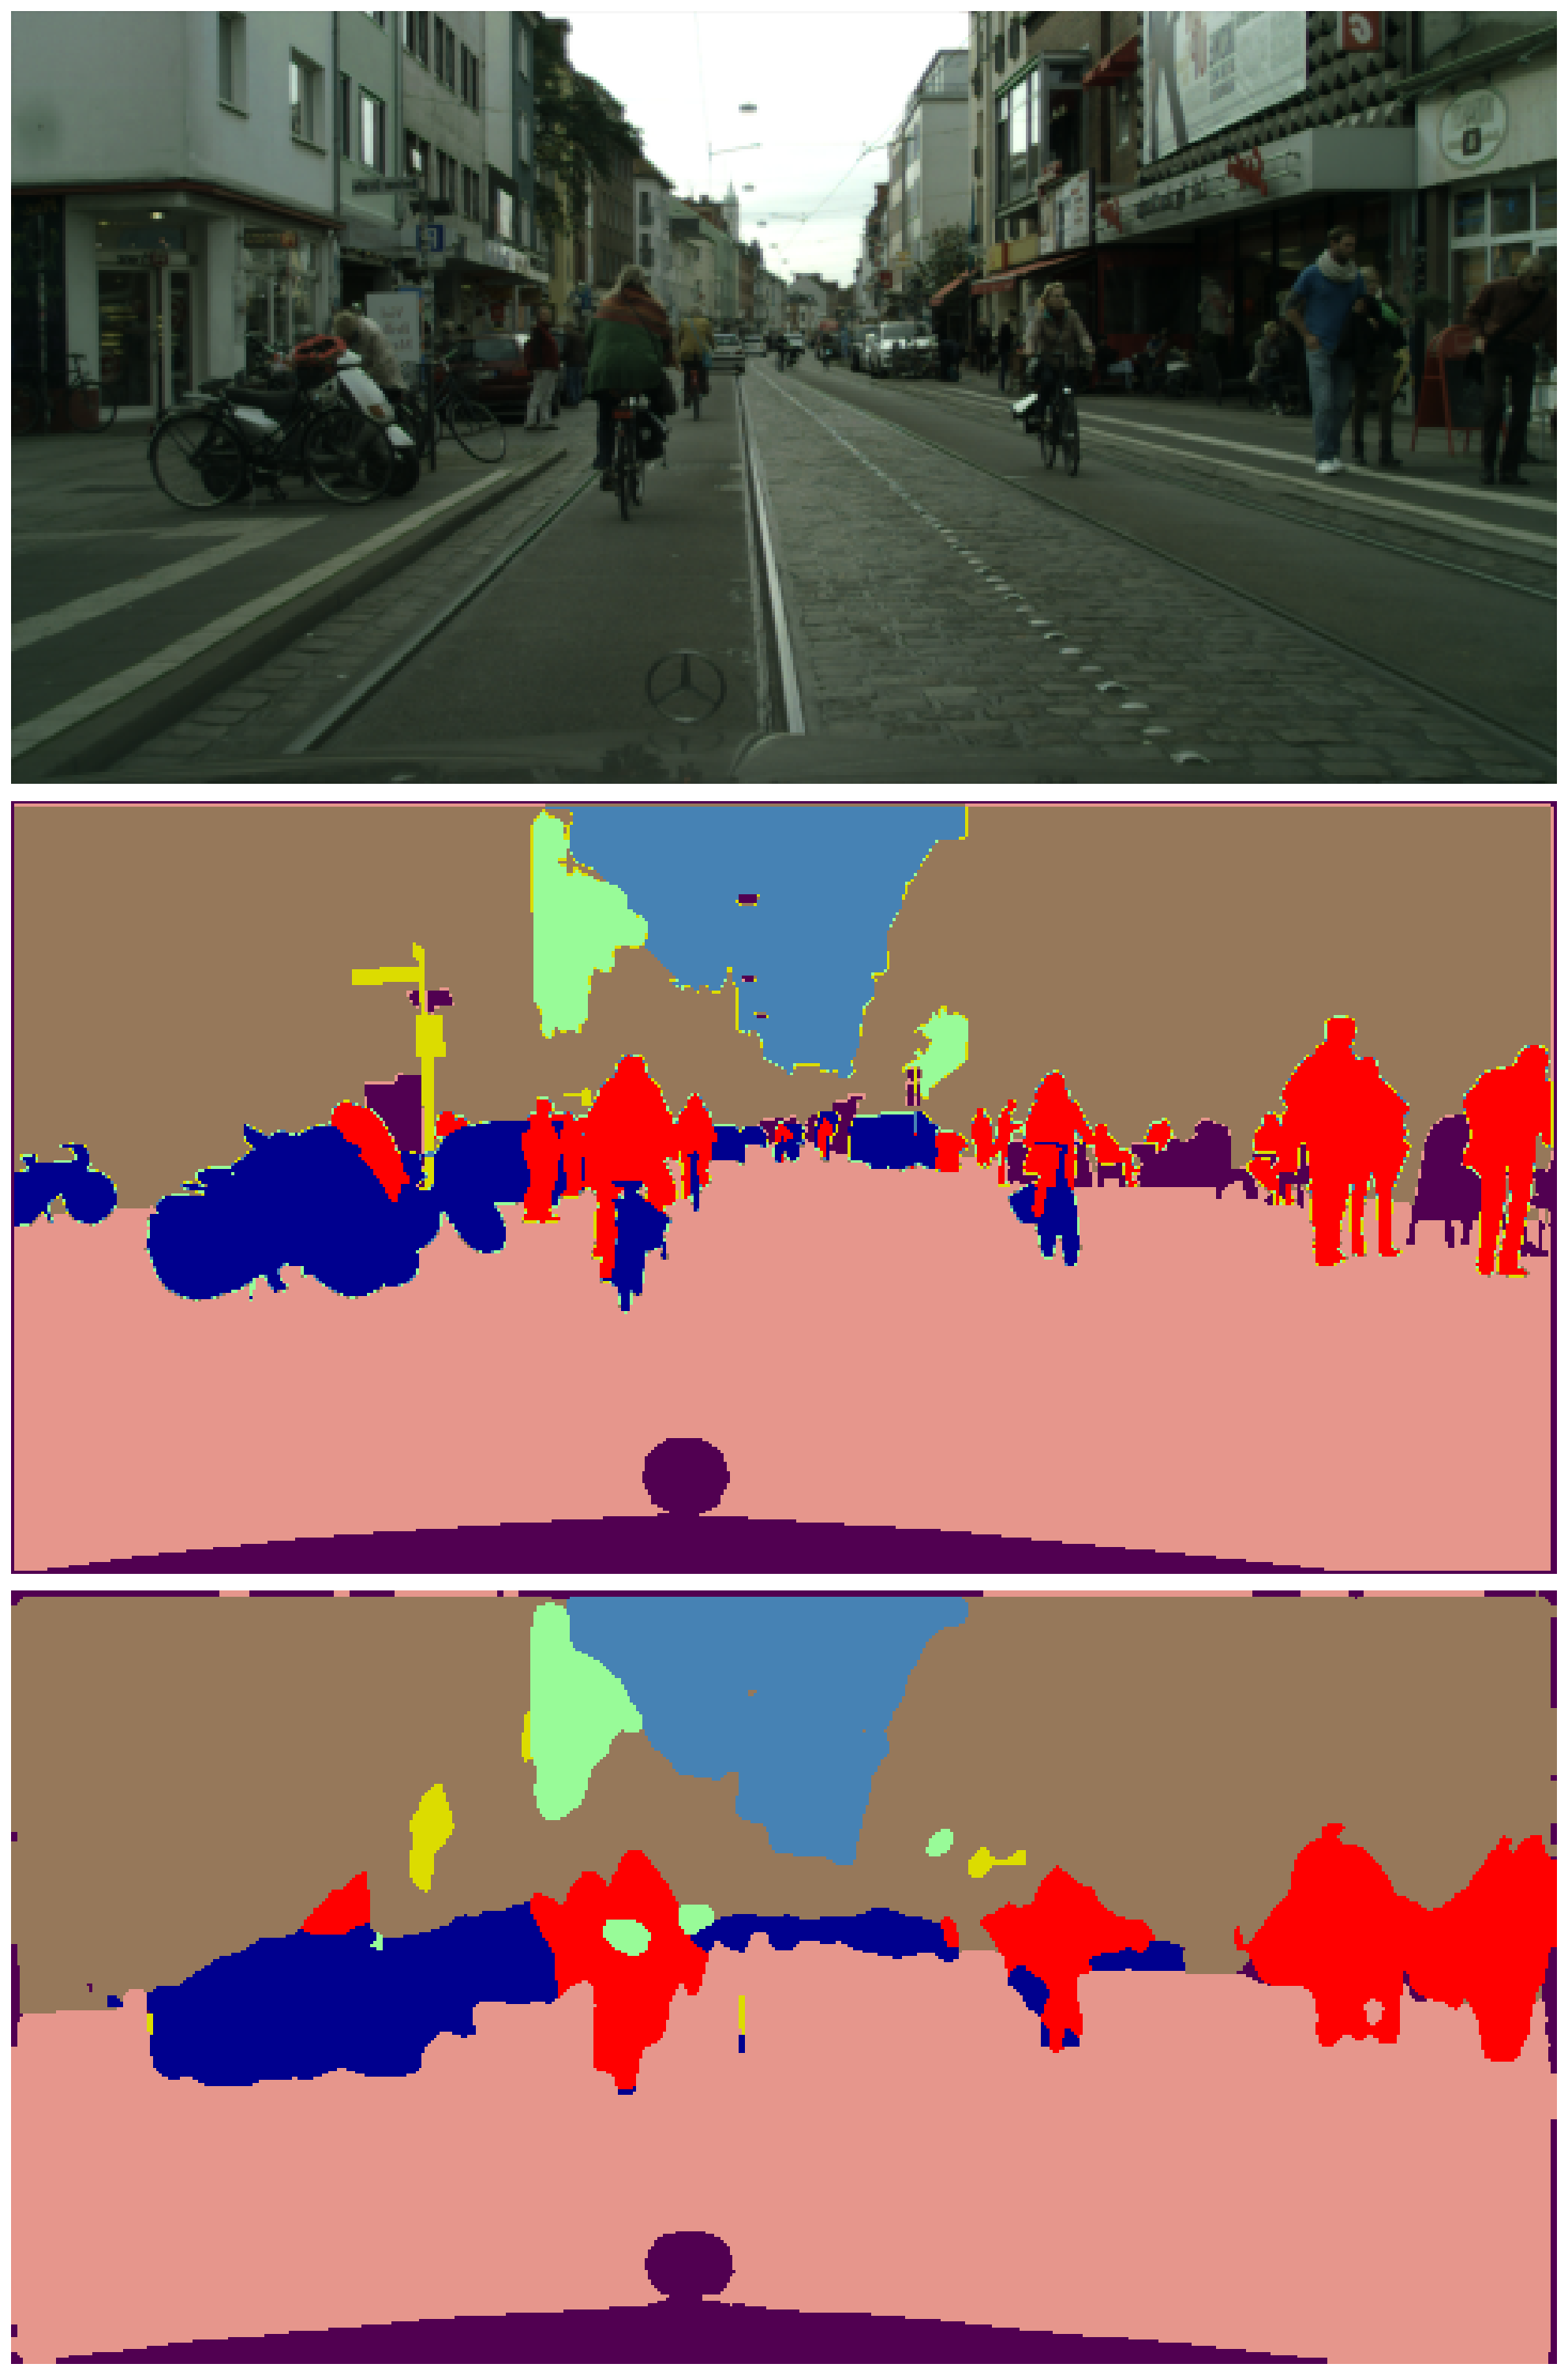


Sample Prediction after epoch 48


Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 00048: early stopping


In [23]:
results = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs = (EPOCHS*SUBSPLITS),
    validation_data = test_dataset,
    callbacks = callbacks,
    verbose = 1
)

In [24]:
if fine:
    model.save_weights(PATH_fine)
else:
    model.save_weights(PATH_coarse)

In [25]:
# results = model.history

In [26]:
def plot_history(results, model):
        
    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)  
    if model.name == "u2net":
        plt.plot(results.history['d0_loss'], 'r', label='Training loss')
        plt.plot(results.history['val_d0_loss'], 'b', label='Validation loss')
    else: 
        plt.plot(results.history['loss'], 'r', label='Training loss')
        plt.plot(results.history['val_loss'], 'b', label='Validation loss')
    plt.title("Log Loss: "+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,2)
    if model.name == "u2net":
        plt.plot(results.history['d0_accuracy'], 'r', label='Training accuracy')
        plt.plot(results.history['val_d0_accuracy'], 'b', label='Validation accuracy')
    else:
        plt.plot(results.history['accuracy'], 'r', label='Training accuracy')
        plt.plot(results.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Accuracy: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,3)
    if model.name == "u2net":
        plt.plot(results.history['d0_iou_coef'], 'r', label='IoU coefficient')
        plt.plot(results.history['val_d0_iou_coef'], 'b', label='Validation IoU coefficient')
    else:
        plt.plot(results.history['iou_coef'], 'r', label='IoU coefficient')
        plt.plot(results.history['val_iou_coef'], 'b', label='Validation IoU coefficient')
    plt.title('IoU Coefficient: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})
    if fine:
        plt.savefig("plots/"+model.name+"_learning_curves.png")
    else:
        plt.savefig("plots/"+model.name+"_learning_curves.png")
    plt.show()

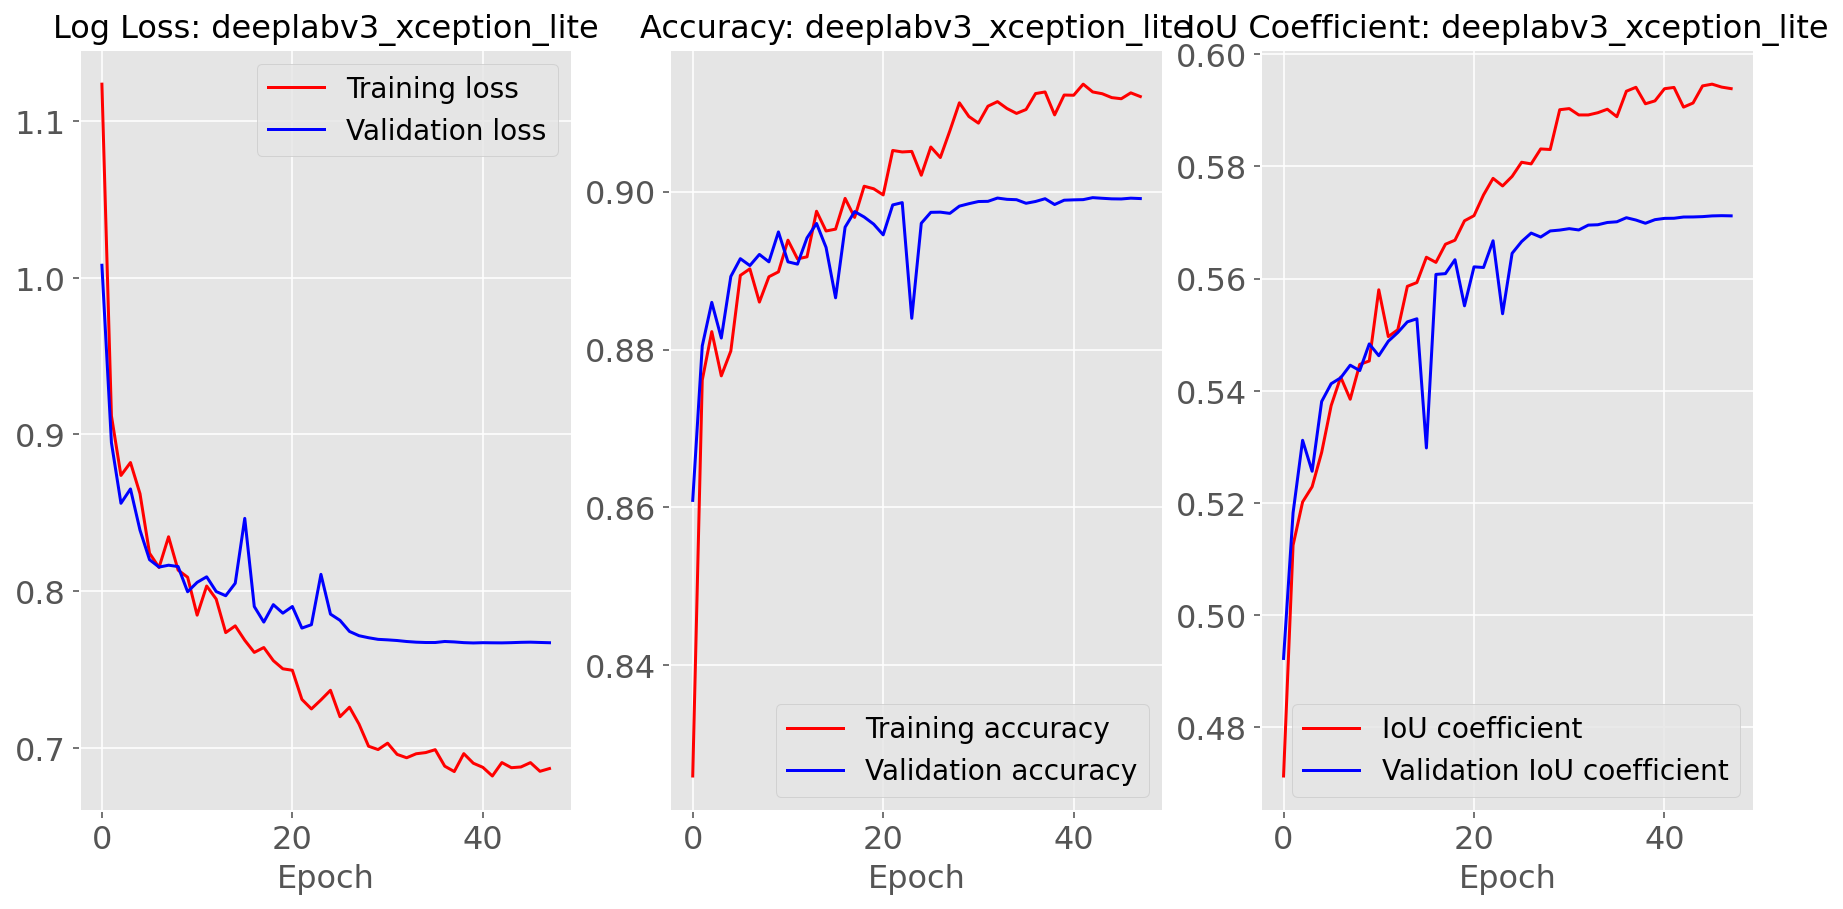

In [27]:
plot_history(results, model)

In [28]:
def get_mean_iou(y_true, y_pred):
    """ Absent classes contribute to the class mean as 1.0 """
    iou = 0.0
    smooth = 1.0
    iou_class = []
    for i in range(1, n_classes):
        intersection = K.sum(y_true[:,:,:,i] * y_pred[:,:,:,i], axis=(1,2))
        union = K.sum(y_true[:,:,:,i] + y_pred[:,:,:,i], axis=(1,2)) - intersection
        iou_temp = K.mean((intersection + smooth) / (union + smooth))
        iou_class.append(iou_temp.numpy())
        iou = iou + iou_temp
    iou_mean = iou / n_classes
    return iou_class, iou_mean.numpy()


def evaluate_iou(model, dataset, n_samples):
    
    iou_class_scores = np.zeros((n_samples, n_classes-1))
    iou_mean_scores = np.zeros((n_samples,))
    
    for idx, (image, mask) in enumerate(dataset):
        print("\r Predicting {} \ {} ".format(idx+1, n_samples), end='')
        
        X = image.numpy()
        y_true = np.expand_dims(mask.numpy(), axis=0)
        y_pred = model.predict(np.expand_dims(X, axis=0))
        if model.name == "u2net":
            y_pred = y_pred[0]
        
        iou_class, iou_mean = get_mean_iou(y_true, y_pred)
        iou_class_scores[idx] = iou_class
        iou_mean_scores[idx] = iou_mean
        
        if idx == (n_samples-1):
            break
            
    return np.mean(iou_class_scores, axis=0), np.mean(iou_mean_scores)

In [29]:
iou_class, iou_mean = evaluate_iou(model=model, dataset=test, n_samples=TEST_LENGTH)

 Predicting 695 \ 695 

In [30]:
print("IoU Score: {:.4f}".format(iou_mean))

IoU Score: 0.4952


#### Train Ids: Best IoU: 0.4250
#### Category Ids: Best IoU: 0.5914

In [31]:
def plot_iou_trainId(Id2label, n_classes, iou_class, model):
    categories = [Id2label[i].category for i in range(n_classes)]
    cmap = [color['color'] for color in plt.rcParams['axes.prop_cycle']]
    cat_colors = {
        'void': 'black',
        'flat': cmap[0],
        'construction': cmap[1],
        'object': cmap[2],
        'nature': cmap[3],
        'sky': cmap[4],
        'human': cmap[5],
        'vehicle': cmap[6]
    }
    colors = [cat_colors[category] for category in categories]

    names = [Id2label[i].name for i in range(n_classes)]

    plt.figure(figsize=(14,10), dpi=200)
    plt.barh(names, iou_class, color=colors)
    plt.xlabel("IoU Coefficient: ", fontsize=18)
    plt.ylabel("Class Name", fontsize=18)
    plt.title("Class IoU Score: "+model.name, fontsize=22)
    plt.xlim([0, 1])
    if fine:
        plt.savefig("plots/"+model.name+"_iou_scores.png")
    else:
        plt.savefig("plots/"+model.name+"_iou_scores_coarse.png")
    plt.show()
    
    
def plot_iou_catId(Id2label, n_classes, iou_class, model, iou_mean):
    categories = [Id2label[i+1].category for i in range(n_classes-1)]
    cmap = [color['color'] for color in plt.rcParams['axes.prop_cycle']]
    cat_colors = {
        'void': 'black',
        'flat': cmap[0],
        'construction': cmap[1],
        'object': cmap[2],
        'nature': cmap[3],
        'sky': cmap[4],
        'human': cmap[5],
        'vehicle': cmap[6]
    }
    colors = [cat_colors[category] for category in categories]

    plt.figure(figsize=(14,10), dpi=200)
    plt.barh(categories, iou_class, color=colors)
    plt.xlabel("IoU Coefficient", fontsize=18)
    plt.ylabel("Category Name", fontsize=18)
    plt.title("Category IoU Scores for {} - Average: {:.3f}".format(model.name, iou_mean), fontsize=22)
    plt.xlim([0, 1])
    if fine:
        plt.savefig("plots/"+model.name+"_iou_scores.png")
    else:
        plt.savefig("plots/"+model.name+"_iou_scores_coarse.png")
    plt.show()

In [32]:
# plot_iou_trainId(Id2label=trainId2label, n_classes=n_classes, iou_class=iou_class, model)

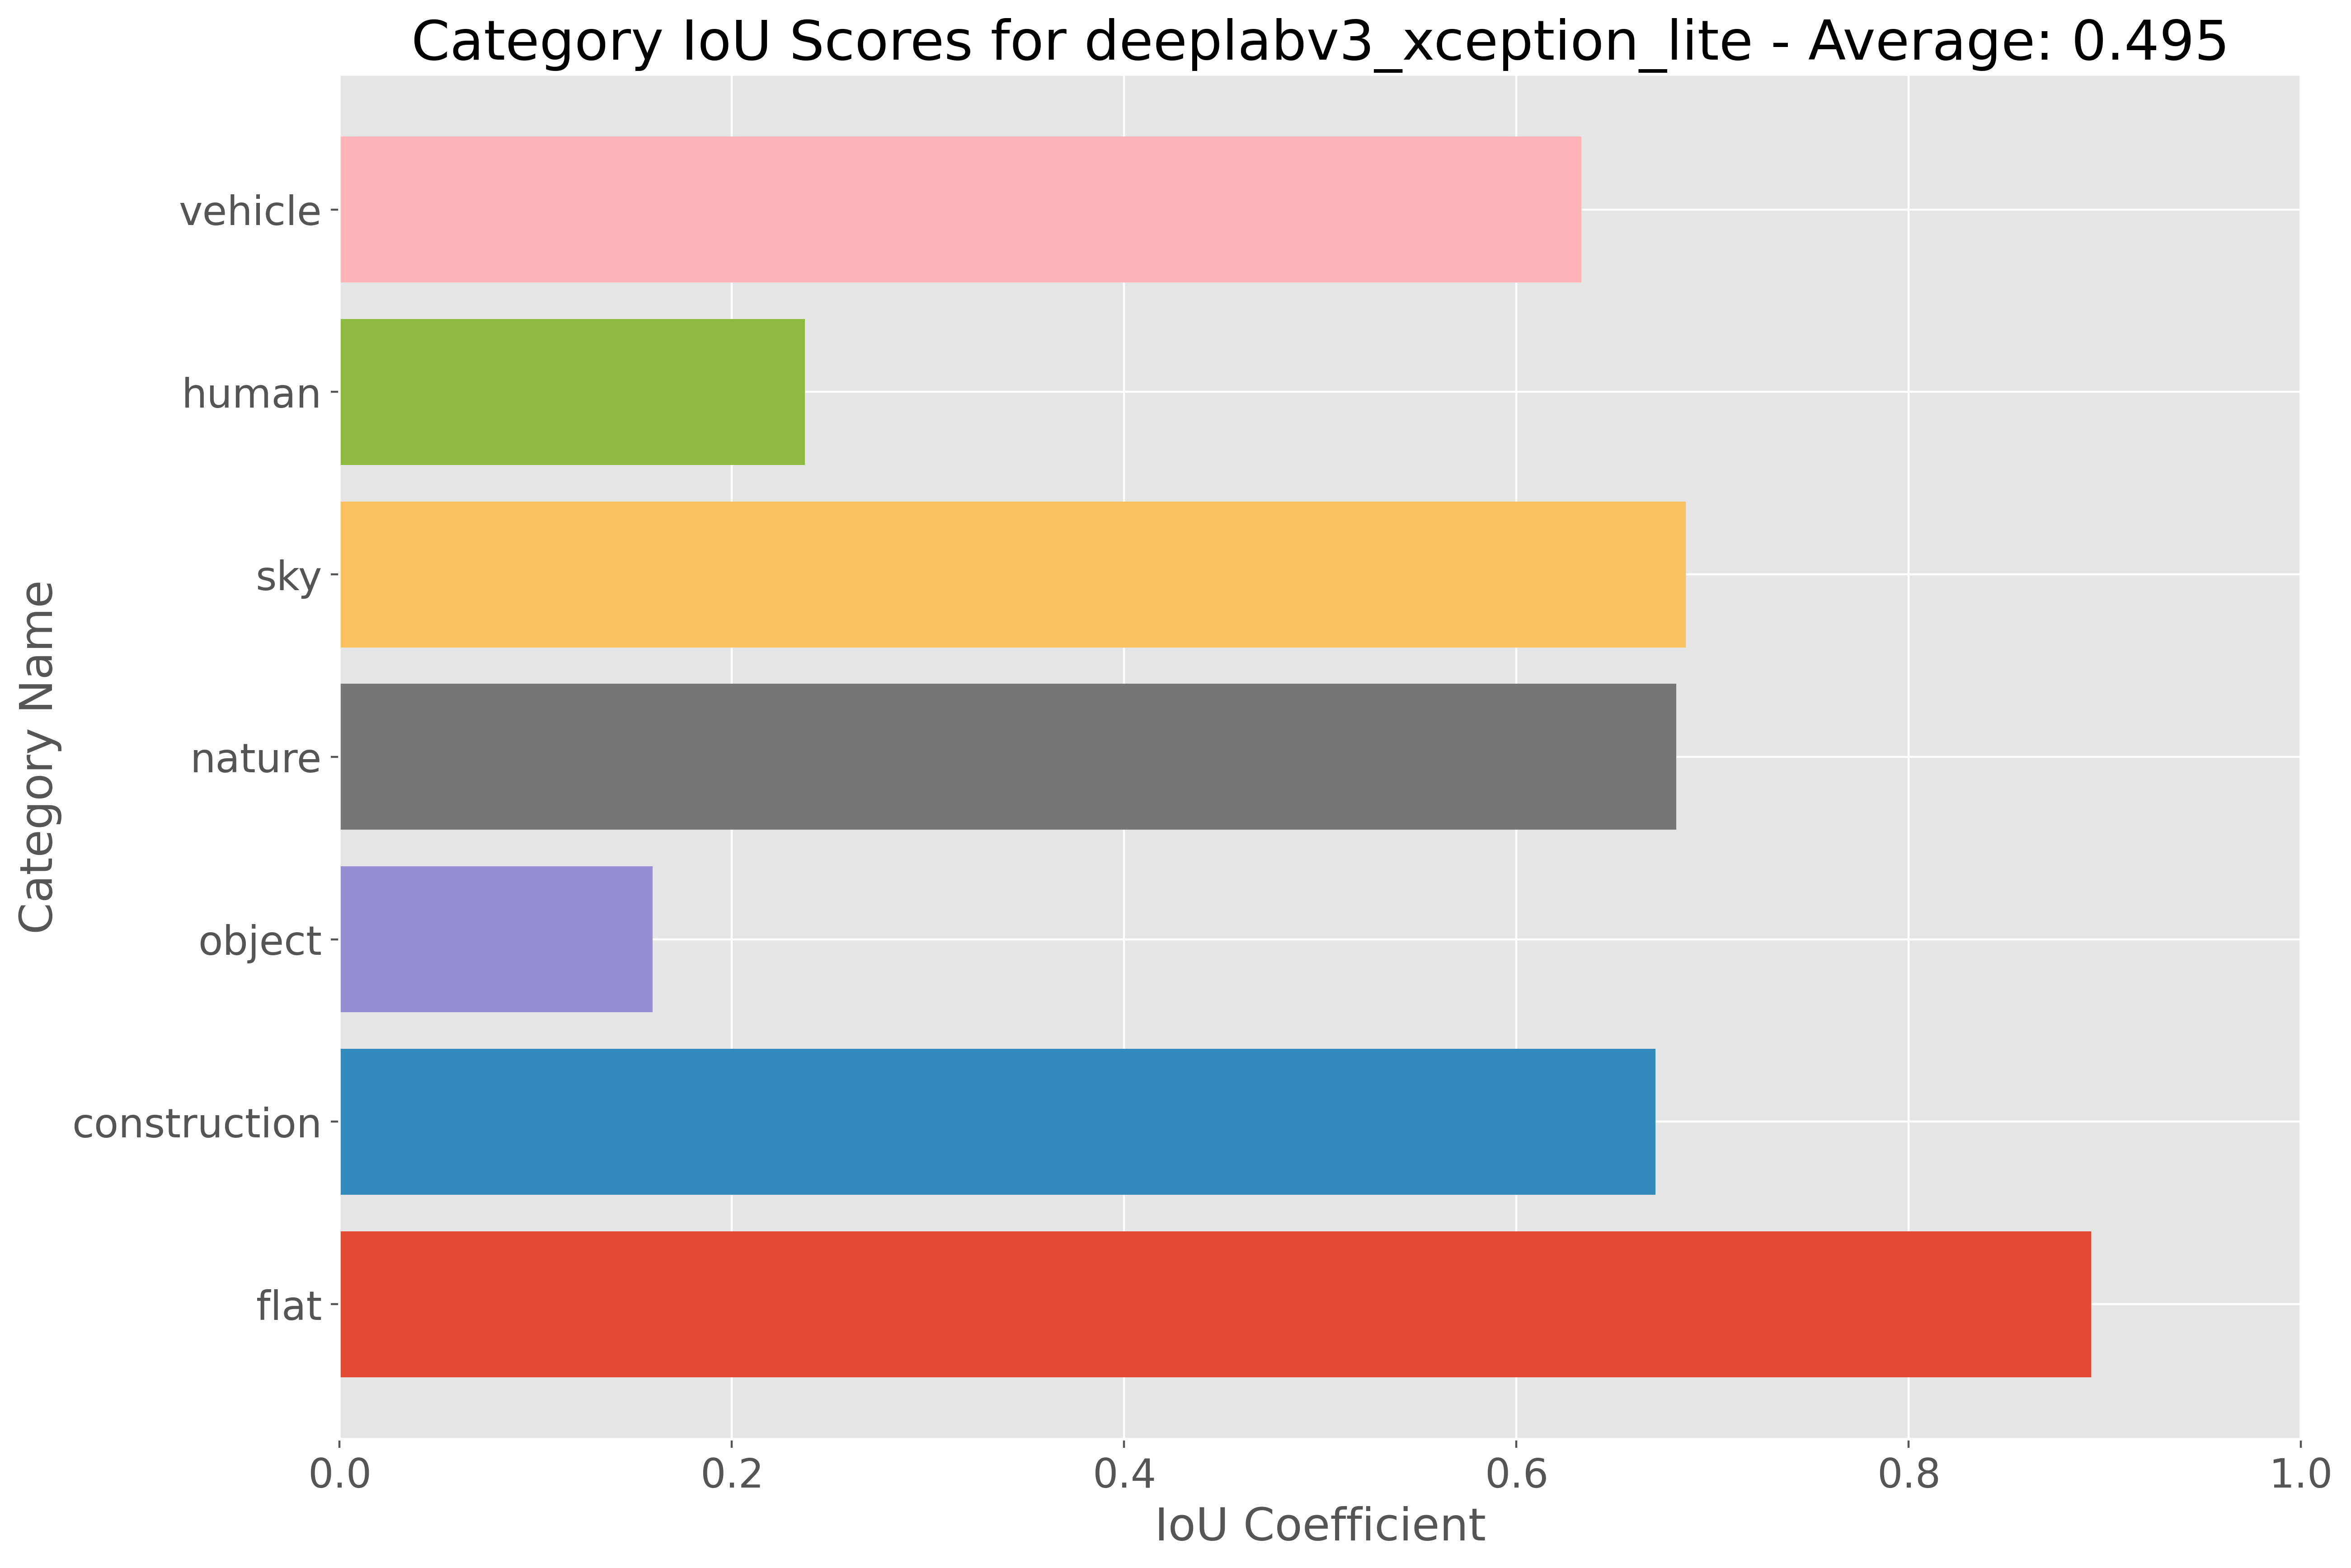

In [33]:
plot_iou_catId(Id2label=catId2label, n_classes=n_classes, iou_class=iou_class, model=model, iou_mean=iou_mean)